<a href="https://colab.research.google.com/github/shin0105/4YP/blob/main/mllcalc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install GPyOpt --quiet
!pip install GPy --quiet

In [2]:
#import packages

#basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d

#Bayesian optimization packages
import GPy
import GPyOpt

#ML Algorithm packages
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import preprocessing

In [3]:
#dataset = UCI Car Evaluation
names=['buying','maint','doors','persons','lug_boot','safety','class']
df = pd.read_csv('car.data', names = names)
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [ ]:
#frequency distribution
for col in names: 
    print(df[col].value_counts())

#replacing ? into NaT
df=df.replace('?',pd.NaT)

#checking missing values
df.isnull().sum()

In [ ]:
#dropping rows with missing values
df=df.dropna()
print(df.isnull().sum())

In [6]:
#Convert categorical labels to numbers
le = preprocessing.LabelEncoder()

for col in names: 
  df[col] = le.fit_transform(df[col])

In [7]:
X = df.drop(['class'], axis=1)
y = df['class']

#splitting train data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [8]:
#K-fold validation
def kfold_score(clf,X,y,n_fold):
    X,y = X.values,y.values
    kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)
    accuracy_list = []

    for train_index, test_index in kfold.split(X, y):
        x_train_fold, x_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        clf.fit(x_train_fold, y_train_fold)
        preds = clf.predict(x_test_fold)
        accuracy_test = accuracy_score(preds,y_test_fold)
        accuracy_list.append(accuracy_test)
    return np.array(accuracy_list).mean()

In [9]:
#Random Forest classification

#max_features: 1 to around sqrt(# of features of dataset)
bounds = [
        {'name': 'max_features', 'type': 'continuous', 'domain': (1, 5)},
        {'name': 'n_estimators', 'type': 'continuous', 'domain': (1, 200)}
      ]

def rf_score(parameters):
  params = {
        'max_features':int(parameters[0][0]),
        'n_estimators':int(parameters[0][1])
    }
  
  clf = RandomForestClassifier(max_features=params['max_features'],n_estimators=params['n_estimators'])
  clf.fit(X_train,y_train)
  score = kfold_score(clf,X_train, y_train,10)
  return score

In [10]:
import numpy as np

arr1 = np.array([1, 2, 3])
col_vector = np.column_stack([arr1])

arr2 = np.array([4, 5, 6])
arr2 = np.column_stack([arr2])
arr = np.hstack((col_vector, arr2))
print(arr)

[[1 4]
 [2 5]
 [3 6]]


In [11]:
p1=[1,2,3,4,5]
p2=np.linspace(1,200,51)
p1list=[]
p2list=[]
scorelist=[]
for i in range(len(p1)):
  for j in range(len(p2)):
    clf = RandomForestClassifier(max_features=p1[i],n_estimators=int(p2[j]))
    clf.fit(X_train,y_train)
    score = kfold_score(clf,X_train, y_train,10)
    p1list.append(p1[i])
    p2list.append(int(p2[j]))
    scorelist.append(score)

p1list_ = np.column_stack([p1list])
p2list_ = np.column_stack([p2list])
scorelist_ = np.column_stack([scorelist])

In [12]:
X=np.hstack((p1list_,p2list_))
Y=scorelist_

In [13]:
kernel = GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=1,active_dims=[0]) * GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=1,active_dims=[1])
m = GPy.models.GPRegression(X,Y,kernel)
m

GP_regression.,value,constraints,priors
mul.Mat52.variance,1.0,+ve,
mul.Mat52.lengthscale,1.0,+ve,
mul.Mat52_1.variance,1.0,+ve,
mul.Mat52_1.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


In [14]:
m.optimize()
m

GP_regression.,value,constraints,priors
mul.Mat52.variance,0.6196571566699238,+ve,
mul.Mat52.lengthscale,11.954683143774856,+ve,
mul.Mat52_1.variance,0.6196571563265283,+ve,
mul.Mat52_1.lengthscale,84.76627392742544,+ve,
Gaussian_noise.variance,8.2330673660975e-06,+ve,


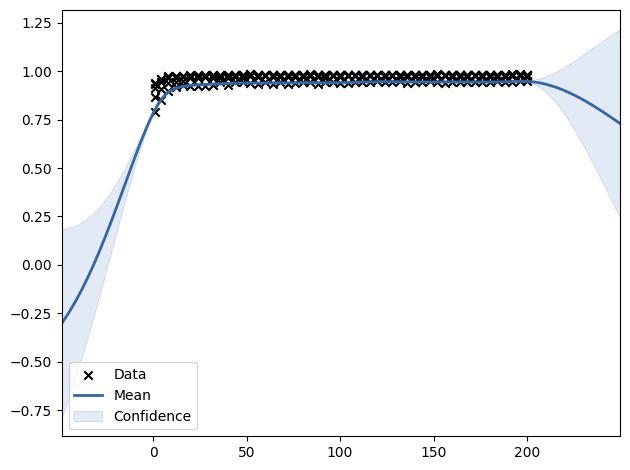

In [15]:
_ = m.plot(fixed_inputs=[(0, 1)])

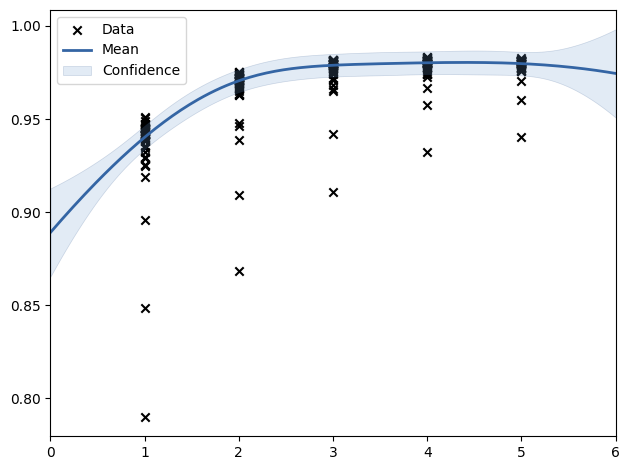

In [16]:
_ = m.plot(fixed_inputs=[(1, 100)])

In [17]:
kernel1 = GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=1,active_dims=[0])
kernel2 = GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=1,active_dims=[1])
kernel3 = GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=1,active_dims=[0]) \
        * GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=1,active_dims=[1])
kernel = kernel1 + kernel2 + kernel3
m = GPy.models.GPRegression(X, Y, kernel)

In [18]:
m

GP_regression.,value,constraints,priors
sum.Mat52.variance,1.0,+ve,
sum.Mat52.lengthscale,1.0,+ve,
sum.Mat52_1.variance,1.0,+ve,
sum.Mat52_1.lengthscale,1.0,+ve,
sum.mul.Mat52.variance,1.0,+ve,
sum.mul.Mat52.lengthscale,1.0,+ve,
sum.mul.Mat52_1.variance,1.0,+ve,
sum.mul.Mat52_1.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


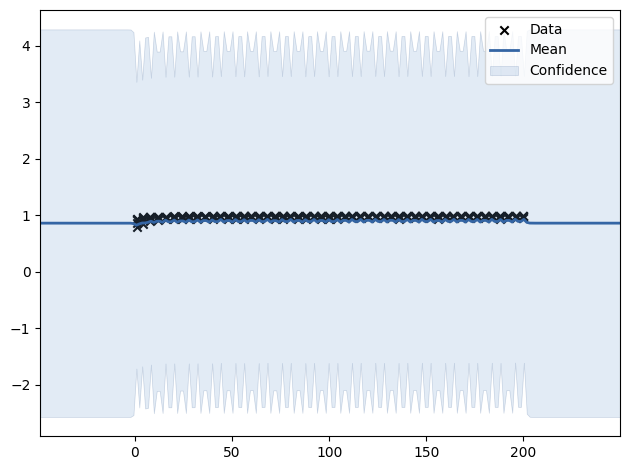

In [19]:
_ = m.plot(fixed_inputs=[(0, 1)])

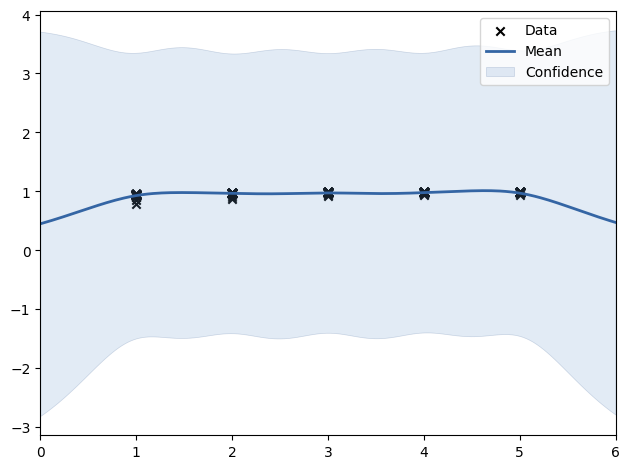

In [20]:
_ = m.plot(fixed_inputs=[(1, 100)])

In [21]:
m.optimize()
m

GP_regression.,value,constraints,priors
sum.Mat52.variance,0.4432157825650662,+ve,
sum.Mat52.lengthscale,18.038126803142738,+ve,
sum.Mat52_1.variance,1.6639325154066032e-12,+ve,
sum.Mat52_1.lengthscale,5.434046558709431,+ve,
sum.mul.Mat52.variance,0.26550844908587923,+ve,
sum.mul.Mat52.lengthscale,9.696394668585361,+ve,
sum.mul.Mat52_1.variance,0.2655084480910327,+ve,
sum.mul.Mat52_1.lengthscale,56.74253790679822,+ve,
Gaussian_noise.variance,7.976584297703362e-06,+ve,


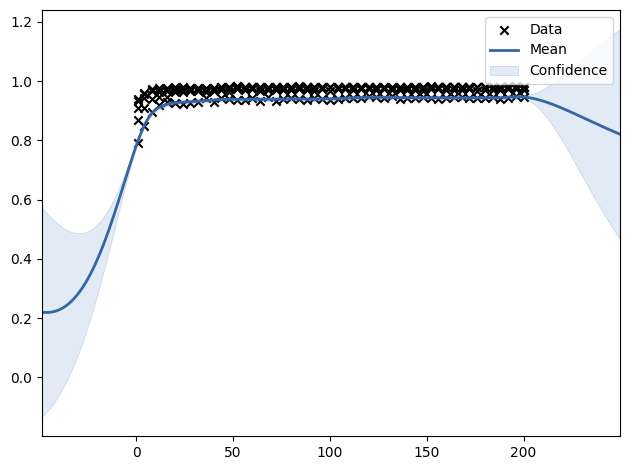

In [22]:
_ = m.plot(fixed_inputs=[(0, 1)])

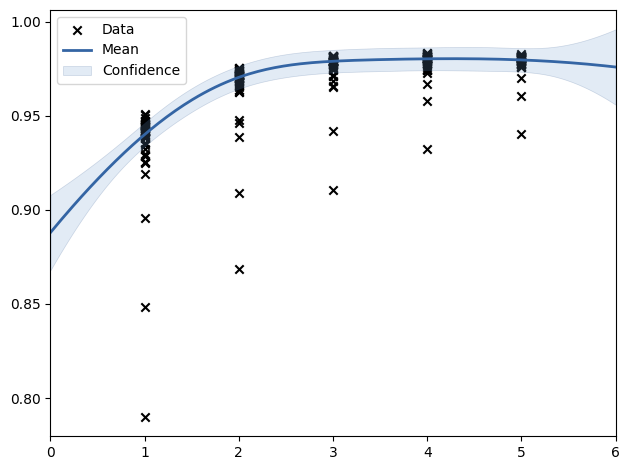

In [23]:
_ = m.plot(fixed_inputs=[(1, 100)])

In [24]:
#SVM Classification

bounds = [ {'name': 'C', 'type': 'continuous', 'domain': (0.1, 100)},
        {'name': 'gamma', 'type': 'continuous', 'domain': (0.01, 1)}
      ]


def svm_score(parameters):
  params = {
        'C': parameters[0][0],
        'gamma': parameters[0][1]
    }
  
  clf = svm.SVC(C=params['C'],gamma=params['gamma'])
  clf.fit(X_train,y_train)
  score = kfold_score(clf,X_train, y_train,10)

  return score

In [25]:
p1 = np.linspace(-1,2,11)
p2 = np.linspace(-2,0,11)
p1list=[]
p2list=[]
scorelist=[]
for i in range(len(p1)):
  for j in range(len(p2)):
    clf = svm.SVC(C=10**p1[i],gamma=10**p2[j])
    clf.fit(X_train,y_train)
    score = kfold_score(clf,X_train, y_train,10)
    p1list.append(10**p1[i])
    p2list.append(10**p2[j])
    scorelist.append(score)

p1list_ = np.column_stack([p1list])
p2list_ = np.column_stack([p2list])
scorelist_ = np.column_stack([scorelist])

In [26]:
X=np.hstack((p1list_,p2list_))
Y=scorelist_

In [27]:
kernel = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0,active_dims=[0]) * GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0,active_dims=[1])
m = GPy.models.GPRegression(X, Y, kernel)

In [28]:
m

GP_regression.,value,constraints,priors
mul.Mat52.variance,1.0,+ve,
mul.Mat52.lengthscale,1.0,+ve,
mul.Mat52_1.variance,1.0,+ve,
mul.Mat52_1.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


In [29]:
m.optimize()
m

GP_regression.,value,constraints,priors
mul.Mat52.variance,0.7555835767769585,+ve,
mul.Mat52.lengthscale,5.528415477863724,+ve,
mul.Mat52_1.variance,0.75558357677716,+ve,
mul.Mat52_1.lengthscale,0.45530021153791544,+ve,
Gaussian_noise.variance,0.0004890711025626798,+ve,


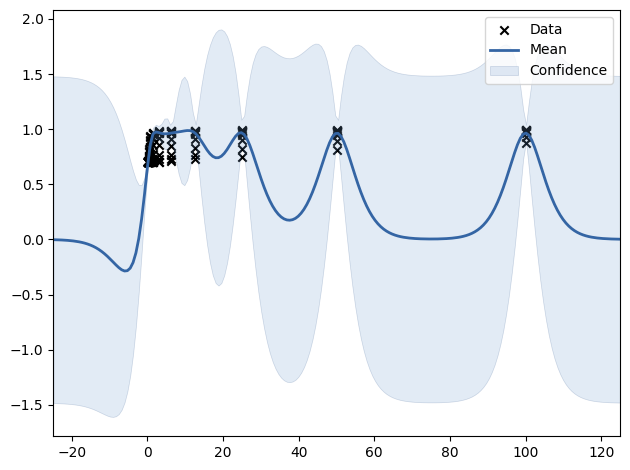

In [30]:
_ = m.plot(fixed_inputs=[(1, 1)])

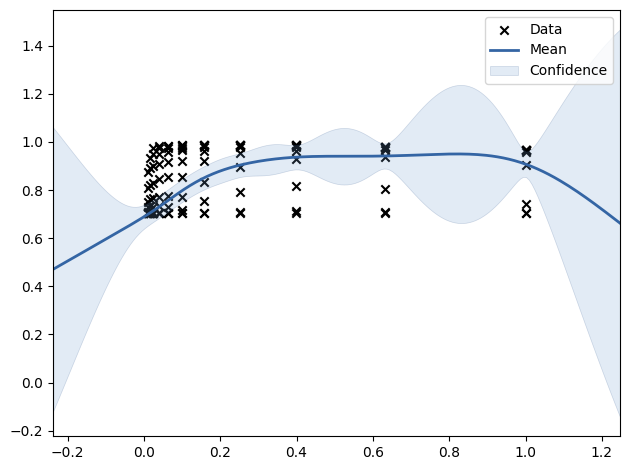

In [31]:
_ = m.plot(fixed_inputs=[(0, 1)])

In [32]:
#KNN Classification

#search domain
bounds = [ {'name': 'leaf_size', 'type': 'continuous', 'domain': (1, 100)},
        {'name': 'n_neighbors', 'type': 'discrete', 'domain': (3,4,5,6,7)}
      ]


def knn_score(parameters):
  params = {
        'leaf_size': int(parameters[0][0]),
        'n_neighbors':int(parameters[0][1])
    }
  
  clf = KNeighborsClassifier(leaf_size=params['leaf_size'],n_neighbors=params['n_neighbors'])
  clf.fit(X_train,y_train)
  score = kfold_score(clf,X_train, y_train,10)

  return score

In [33]:
p1 = np.linspace(1,200,51)
p2 = [3,4,5,6,7,8,9]
p1list=[]
p2list=[]
scorelist=[]
for i in range(len(p1)):
  for j in range(len(p2)):
    clf = KNeighborsClassifier(leaf_size=int(p1[i]),n_neighbors=int(p2[j]))
    clf.fit(X_train,y_train)
    score = kfold_score(clf,X_train, y_train,10)
    p1list.append(p1[i])
    p2list.append(p2[j])
    scorelist.append(score)

p1list_ = np.column_stack([p1list])
p2list_ = np.column_stack([p2list])
scorelist_ = np.column_stack([scorelist])

In [34]:
X=np.hstack((p1list_,p2list_))
Y=scorelist_

In [36]:
kernel = GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=1,active_dims=[0])*GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=1,active_dims=[1])
m = GPy.models.GPRegression(X, Y, kernel)
m

GP_regression.,value,constraints,priors
mul.Mat52.variance,1.0,+ve,
mul.Mat52.lengthscale,1.0,+ve,
mul.Mat52_1.variance,1.0,+ve,
mul.Mat52_1.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


In [37]:
m.optimize()
m

GP_regression.,value,constraints,priors
mul.Mat52.variance,195.3631485301415,+ve,
mul.Mat52.lengthscale,3098.1185867840923,+ve,
mul.Mat52_1.variance,195.3631482820367,+ve,
mul.Mat52_1.lengthscale,461.972995757926,+ve,
Gaussian_noise.variance,8.234043226808033e-05,+ve,


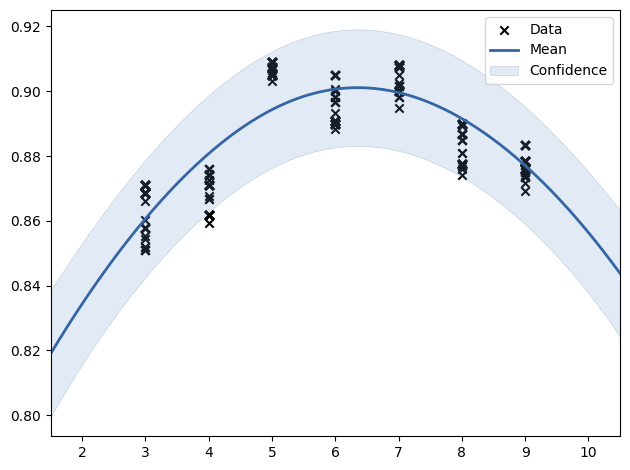

In [38]:
_ = m.plot(fixed_inputs=[(0, 100)])

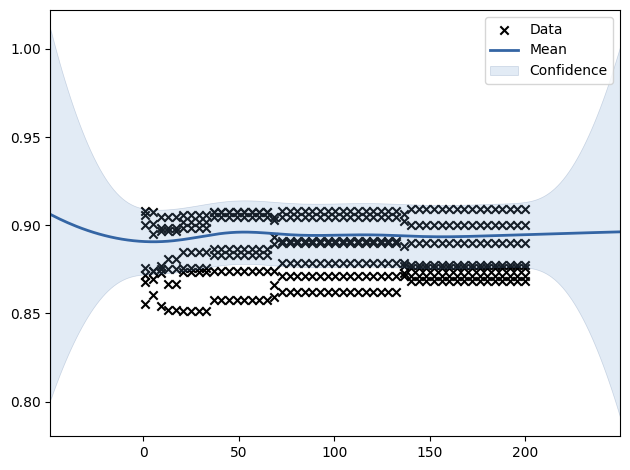

In [39]:
_ = m.plot(fixed_inputs=[(1, 5)])

In [42]:
kernel1 = GPy.kern.StdPeriodic(input_dim=1,variance=1,lengthscale=1,active_dims=[0],period=1) \
          * GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=1,active_dims=[0])
kernel2 = GPy.kern.StdPeriodic(input_dim=1,variance=1,lengthscale=1,active_dims=[1],period=1)
kernel = kernel1 + kernel2
m = GPy.models.GPRegression(X, Y, kernel)

In [43]:
m

GP_regression.,value,constraints,priors
sum.mul.std_periodic.variance,1.0,+ve,
sum.mul.std_periodic.period,1.0,+ve,
sum.mul.std_periodic.lengthscale,1.0,+ve,
sum.mul.Mat52.variance,1.0,+ve,
sum.mul.Mat52.lengthscale,1.0,+ve,
sum.std_periodic.variance,1.0,+ve,
sum.std_periodic.period,1.0,+ve,
sum.std_periodic.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


In [44]:
m.optimize()
m

GP_regression.,value,constraints,priors
sum.mul.std_periodic.variance,4.573062090896645e-14,+ve,
sum.mul.std_periodic.period,0.9971975390148159,+ve,
sum.mul.std_periodic.lengthscale,1.0000136957224646,+ve,
sum.mul.Mat52.variance,4.573062090890633e-14,+ve,
sum.mul.Mat52.lengthscale,1.0266668496465896,+ve,
sum.std_periodic.variance,0.3021807292765133,+ve,
sum.std_periodic.period,0.724289181415937,+ve,
sum.std_periodic.lengthscale,1.3704809334973698,+ve,
Gaussian_noise.variance,2.4944176965829174e-05,+ve,


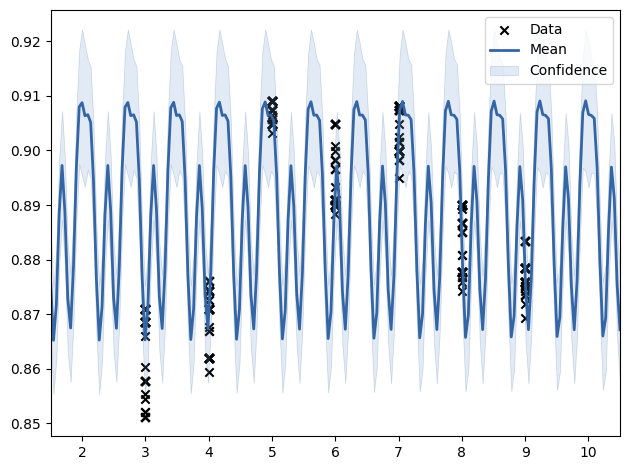

In [45]:
_ = m.plot(fixed_inputs=[(0, 100)])

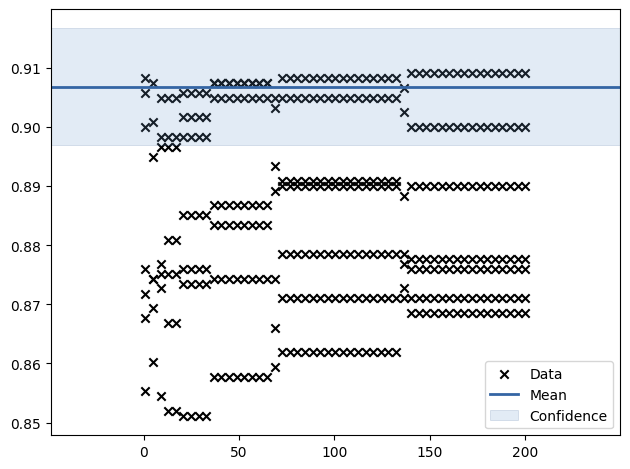

In [46]:
_ = m.plot(fixed_inputs=[(1, 5)])

In [62]:
kernel1 = GPy.kern.StdPeriodic(input_dim=1,variance=1,lengthscale=1,active_dims=[0],period=13) \
          * GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=1,active_dims=[0])
kernel2 = GPy.kern.StdPeriodic(input_dim=1,variance=1,lengthscale=1,active_dims=[1],period=2)
kernel = kernel1 + kernel2
m = GPy.models.GPRegression(X, Y, kernel)
m

GP_regression.,value,constraints,priors
sum.mul.std_periodic.variance,1.0,+ve,
sum.mul.std_periodic.period,13.0,+ve,
sum.mul.std_periodic.lengthscale,1.0,+ve,
sum.mul.Mat52.variance,1.0,+ve,
sum.mul.Mat52.lengthscale,1.0,+ve,
sum.std_periodic.variance,1.0,+ve,
sum.std_periodic.period,2.0,+ve,
sum.std_periodic.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


In [63]:
m.optimize()
m

GP_regression.,value,constraints,priors
sum.mul.std_periodic.variance,4.372030757798082e-14,+ve,
sum.mul.std_periodic.period,13.000215602299148,+ve,
sum.mul.std_periodic.lengthscale,1.0016719641009557,+ve,
sum.mul.Mat52.variance,4.372030757812853e-14,+ve,
sum.mul.Mat52.lengthscale,1.017959235443889,+ve,
sum.std_periodic.variance,0.31169278252971644,+ve,
sum.std_periodic.period,1.7886859332512572,+ve,
sum.std_periodic.lengthscale,1.6654617794008715,+ve,
Gaussian_noise.variance,2.4946202842515782e-05,+ve,


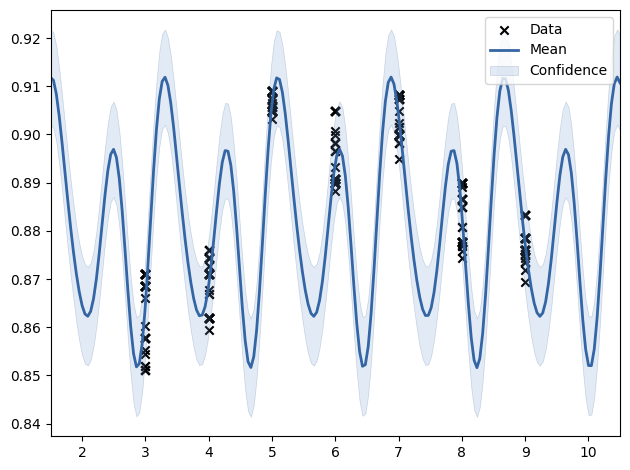

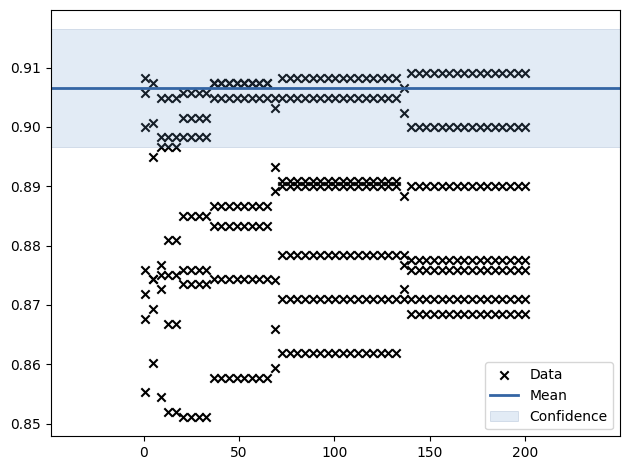

In [64]:
_ = m.plot(fixed_inputs=[(0, 100)])
_ = m.plot(fixed_inputs=[(1, 5)])

In [50]:
kernel1 = GPy.kern.StdPeriodic(input_dim=1,variance=1,lengthscale=1,active_dims=[0],period=13)
kernel2 = GPy.kern.StdPeriodic(input_dim=1,variance=1,lengthscale=1,active_dims=[1],period=2)
kernel = kernel1 + kernel2
m = GPy.models.GPRegression(X, Y, kernel)
m

GP_regression.,value,constraints,priors
sum.std_periodic.variance,1.0,+ve,
sum.std_periodic.period,13.0,+ve,
sum.std_periodic.lengthscale,1.0,+ve,
sum.std_periodic_1.variance,1.0,+ve,
sum.std_periodic_1.period,2.0,+ve,
sum.std_periodic_1.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


In [51]:
m.optimize()
m

GP_regression.,value,constraints,priors
sum.std_periodic.variance,9.312709411009415e-09,+ve,
sum.std_periodic.period,14.895284808012757,+ve,
sum.std_periodic.lengthscale,71.51617615214552,+ve,
sum.std_periodic_1.variance,0.31170722243484283,+ve,
sum.std_periodic_1.period,1.7886670323423377,+ve,
sum.std_periodic_1.lengthscale,1.6655234341149012,+ve,
Gaussian_noise.variance,2.4948955762588907e-05,+ve,


In [52]:
kernel1 = GPy.kern.StdPeriodic(input_dim=1,variance=1,lengthscale=1,active_dims=[0],period=13) * GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=1,active_dims=[0])
kernel2 = GPy.kern.StdPeriodic(input_dim=1,variance=1,lengthscale=1,active_dims=[1],period=2)* GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=1,active_dims=[0])
kernel = kernel1 + kernel2
m = GPy.models.GPRegression(X, Y, kernel)
m

GP_regression.,value,constraints,priors
sum.mul.std_periodic.variance,1.0,+ve,
sum.mul.std_periodic.period,13.0,+ve,
sum.mul.std_periodic.lengthscale,1.0,+ve,
sum.mul.Mat52.variance,1.0,+ve,
sum.mul.Mat52.lengthscale,1.0,+ve,
sum.mul_1.std_periodic.variance,1.0,+ve,
sum.mul_1.std_periodic.period,2.0,+ve,
sum.mul_1.std_periodic.lengthscale,1.0,+ve,
sum.mul_1.Mat52.variance,1.0,+ve,
sum.mul_1.Mat52.lengthscale,1.0,+ve,


In [53]:
m.optimize()
m

GP_regression.,value,constraints,priors
sum.mul.std_periodic.variance,0.8854934268934055,+ve,
sum.mul.std_periodic.period,56956.01755878044,+ve,
sum.mul.std_periodic.lengthscale,331048.5041281216,+ve,
sum.mul.Mat52.variance,0.8857957081976773,+ve,
sum.mul.Mat52.lengthscale,2094939.9814718757,+ve,
sum.mul_1.std_periodic.variance,5.562684646268137e-309,+ve,
sum.mul_1.std_periodic.period,2.012876231791158,+ve,
sum.mul_1.std_periodic.lengthscale,533098.368528379,+ve,
sum.mul_1.Mat52.variance,5.562684646268137e-309,+ve,
sum.mul_1.Mat52.lengthscale,7719.929713931985,+ve,


In [54]:
kernel1 = GPy.kern.StdPeriodic(input_dim=1,variance=1,lengthscale=1,active_dims=[0],period=13)
kernel2 = GPy.kern.StdPeriodic(input_dim=1,variance=1,lengthscale=1,active_dims=[1],period=2)* GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=1,active_dims=[0])
kernel = kernel1 + kernel2
m = GPy.models.GPRegression(X, Y, kernel)
m

GP_regression.,value,constraints,priors
sum.std_periodic.variance,1.0,+ve,
sum.std_periodic.period,13.0,+ve,
sum.std_periodic.lengthscale,1.0,+ve,
sum.mul.std_periodic.variance,1.0,+ve,
sum.mul.std_periodic.period,2.0,+ve,
sum.mul.std_periodic.lengthscale,1.0,+ve,
sum.mul.Mat52.variance,1.0,+ve,
sum.mul.Mat52.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


In [55]:
m.optimize()
m

GP_regression.,value,constraints,priors
sum.std_periodic.variance,0.7278878202577718,+ve,
sum.std_periodic.period,83.50847391534563,+ve,
sum.std_periodic.lengthscale,1068.5142205524576,+ve,
sum.mul.std_periodic.variance,1.8134727206919247e-73,+ve,
sum.mul.std_periodic.period,2.0000003299363045,+ve,
sum.mul.std_periodic.lengthscale,44.92400145471319,+ve,
sum.mul.Mat52.variance,1.8134727207535176e-73,+ve,
sum.mul.Mat52.lengthscale,1.7956162374426439,+ve,
Gaussian_noise.variance,0.00025893324159574345,+ve,


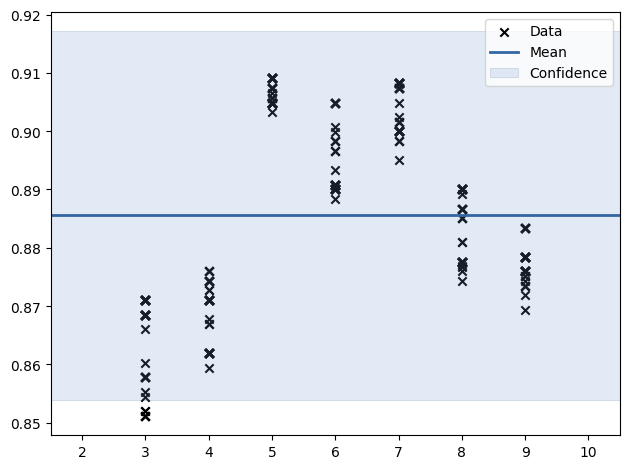

In [56]:
_ = m.plot(fixed_inputs=[(0, 100)])

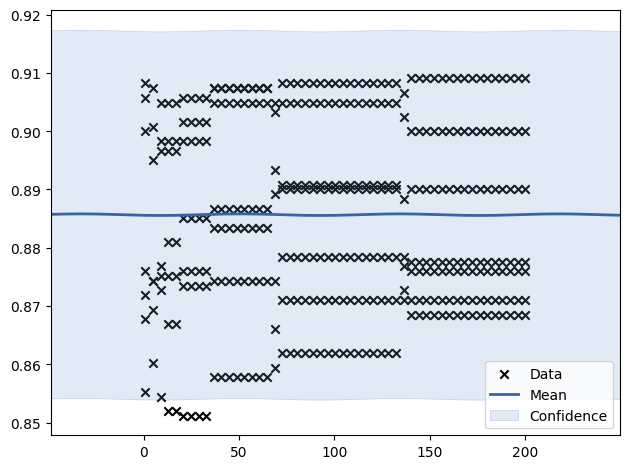

In [57]:
_ = m.plot(fixed_inputs=[(1, 5)])

In [58]:
kernel1 = GPy.kern.StdPeriodic(input_dim=1,variance=1,lengthscale=1,active_dims=[0],period=13)
kernel2 = GPy.kern.StdPeriodic(input_dim=1,variance=1,lengthscale=1,active_dims=[1],period=2)
kernel = kernel1 + kernel2
m = GPy.models.GPRegression(X, Y, kernel)
m

GP_regression.,value,constraints,priors
sum.std_periodic.variance,1.0,+ve,
sum.std_periodic.period,13.0,+ve,
sum.std_periodic.lengthscale,1.0,+ve,
sum.std_periodic_1.variance,1.0,+ve,
sum.std_periodic_1.period,2.0,+ve,
sum.std_periodic_1.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


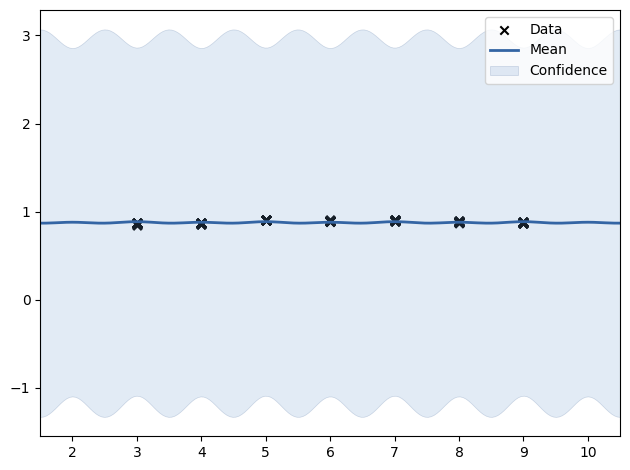

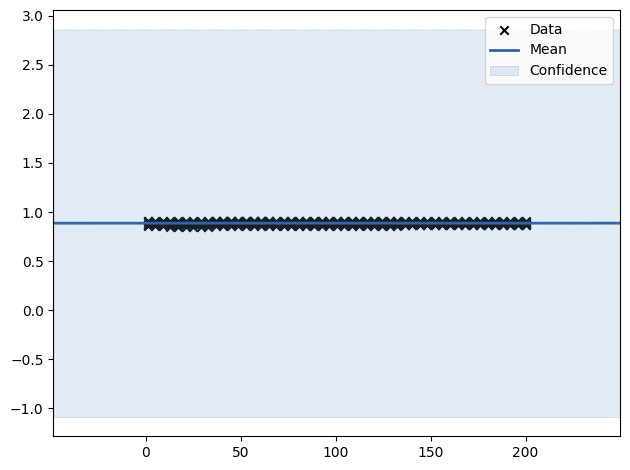

In [59]:
_ = m.plot(fixed_inputs=[(0, 100)])
_ = m.plot(fixed_inputs=[(1, 5)])

In [60]:
m.optimize()
m

GP_regression.,value,constraints,priors
sum.std_periodic.variance,9.312709411009415e-09,+ve,
sum.std_periodic.period,14.895284808012757,+ve,
sum.std_periodic.lengthscale,71.51617615214552,+ve,
sum.std_periodic_1.variance,0.31170722243484283,+ve,
sum.std_periodic_1.period,1.7886670323423377,+ve,
sum.std_periodic_1.lengthscale,1.6655234341149012,+ve,
Gaussian_noise.variance,2.4948955762588907e-05,+ve,


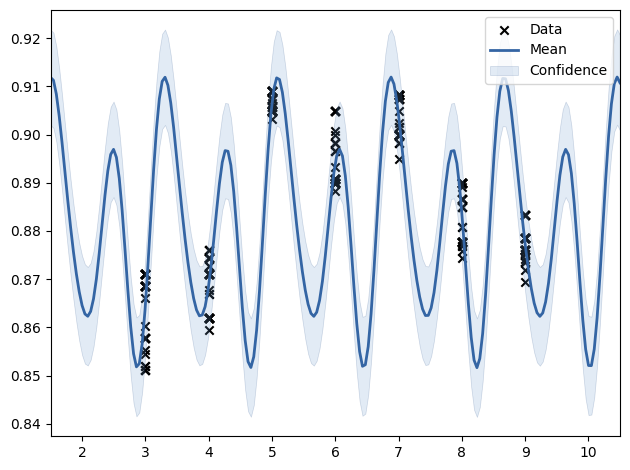

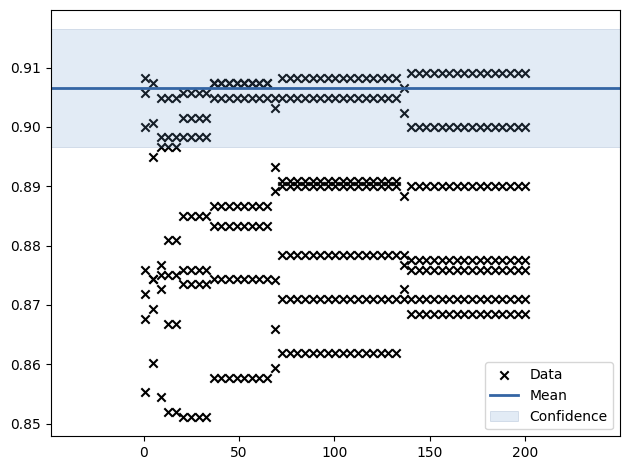

In [61]:
_ = m.plot(fixed_inputs=[(0, 100)])
_ = m.plot(fixed_inputs=[(1, 5)])